# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.pipeline import make_pipeline
import sklearn

In [3]:
set_config(display='diagram')
plt.style.use(["dark_background"])
plt.rcParams["figure.figsize"] = [14.0, 6.0]
sklearn.__version__

'0.24.2'

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

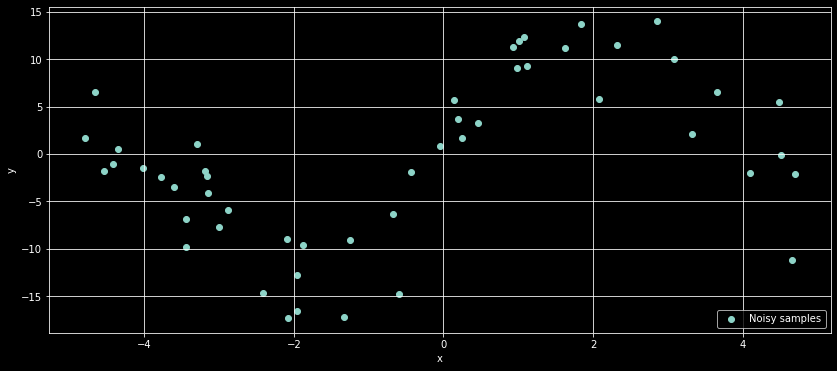

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

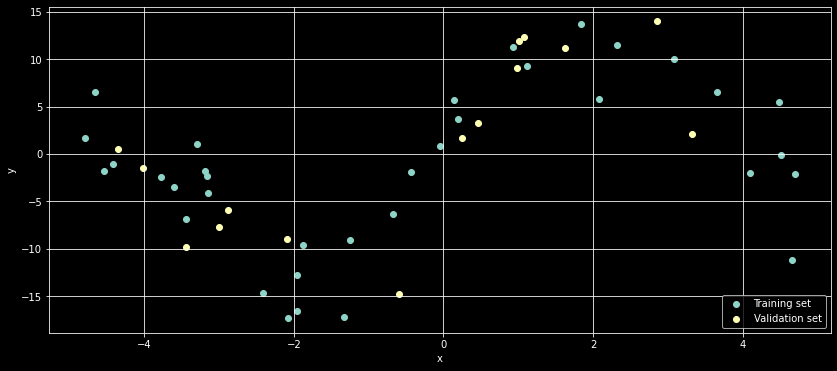

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[[1], [3], [4]])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

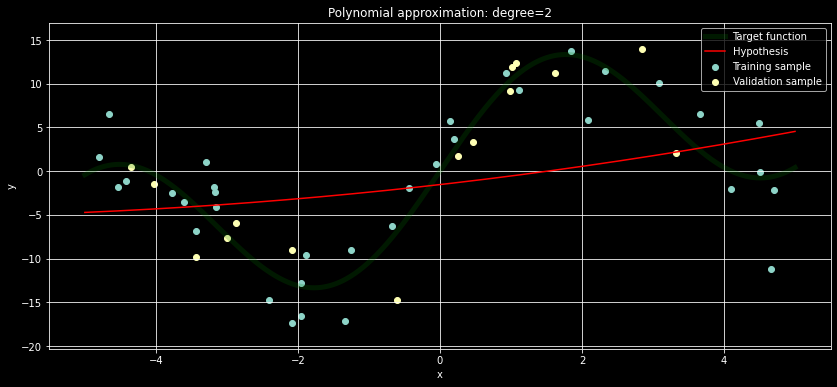

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

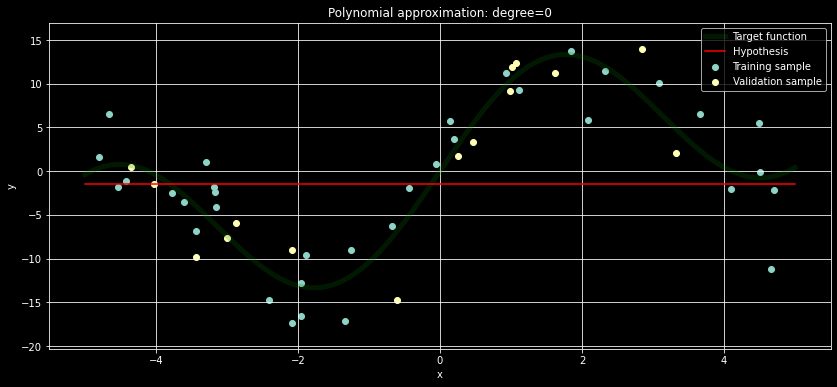

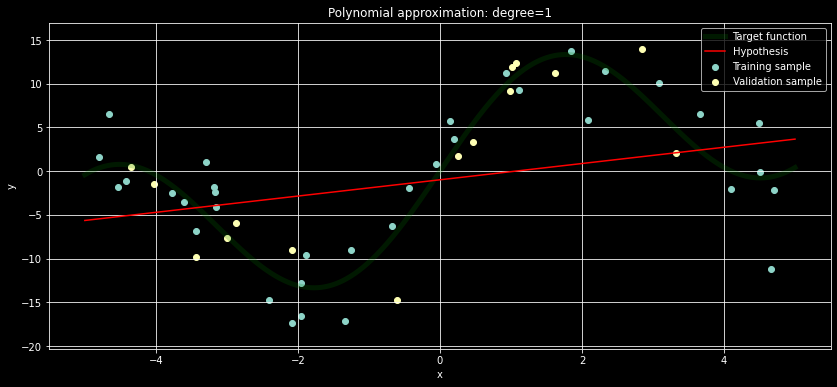

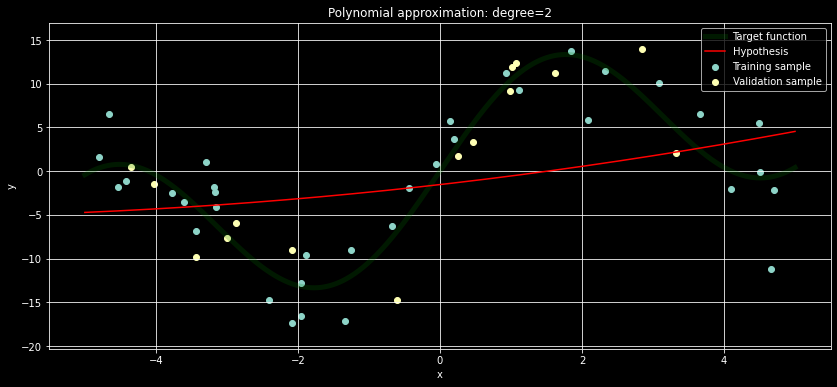

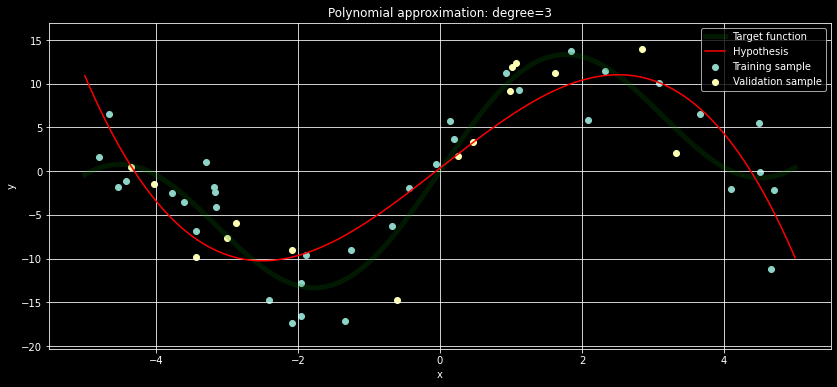

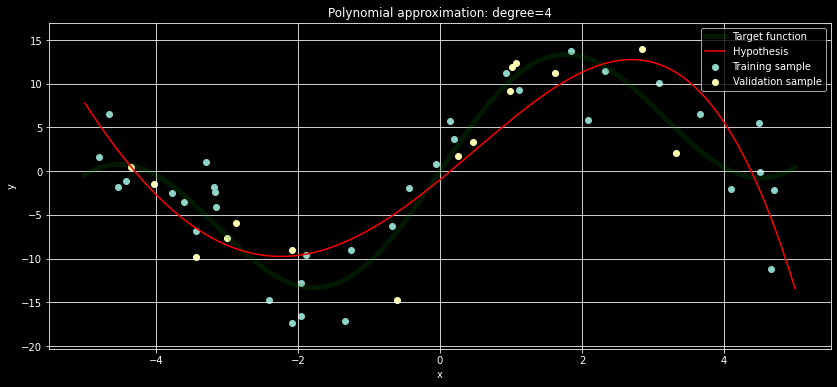

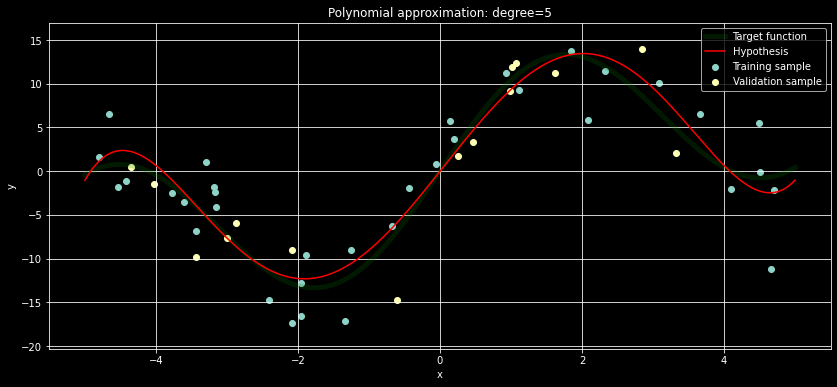

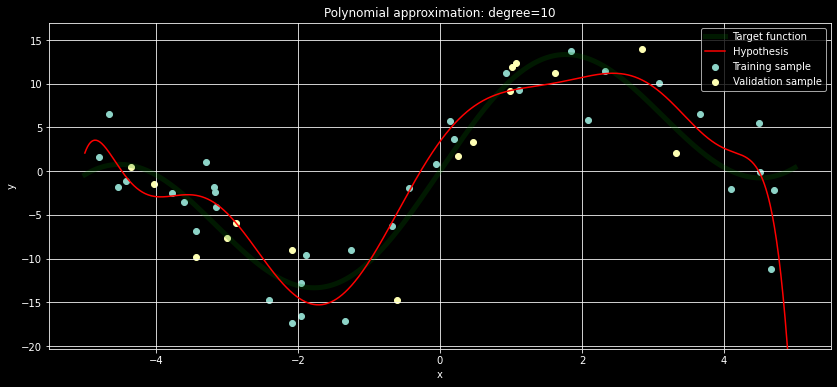

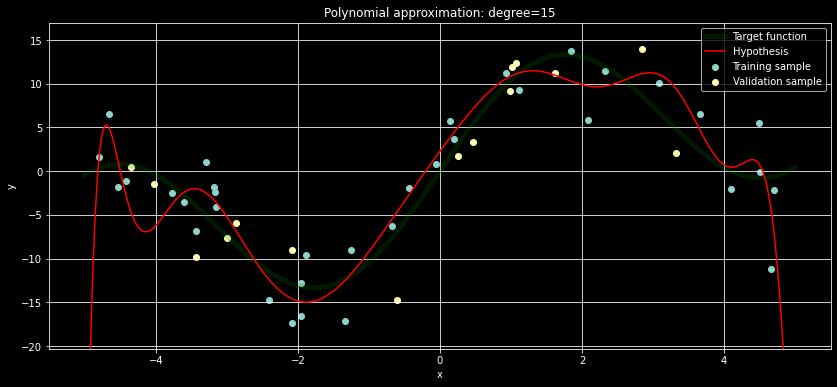

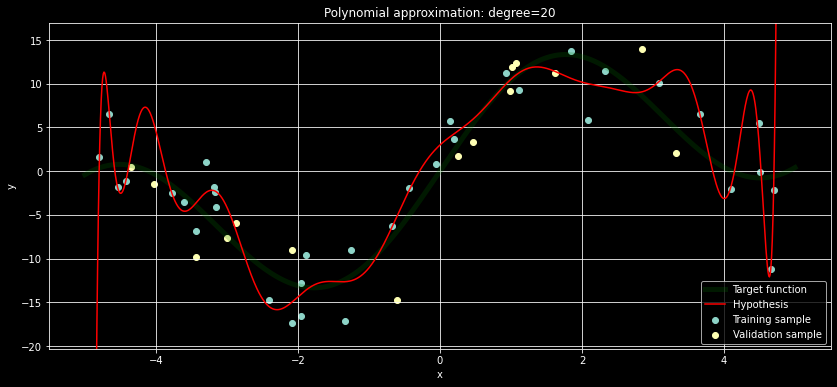

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

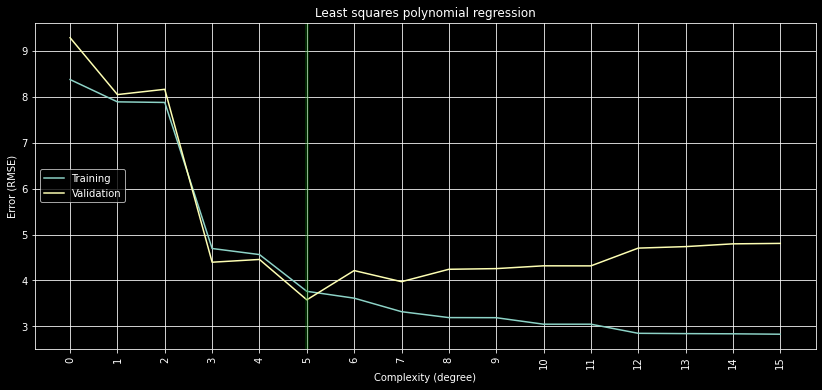

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    # plt.figure(figsize=(9, 4.5))
    plt.figure(figsize=(14, 6))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='g', lw=4, alpha=0.3)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.8, lw=2, ls='dotted', color='w', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

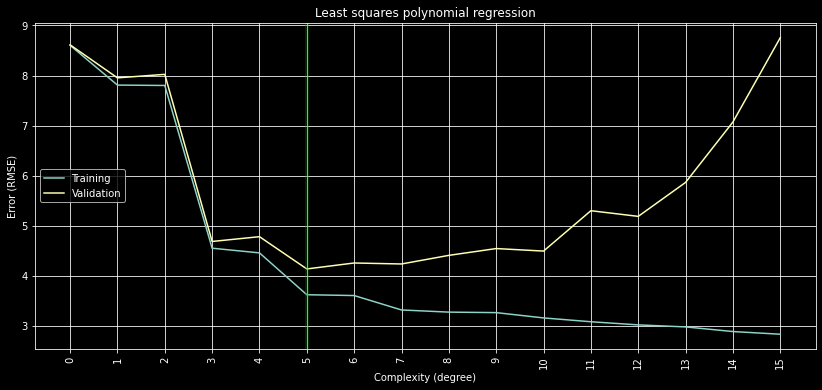

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

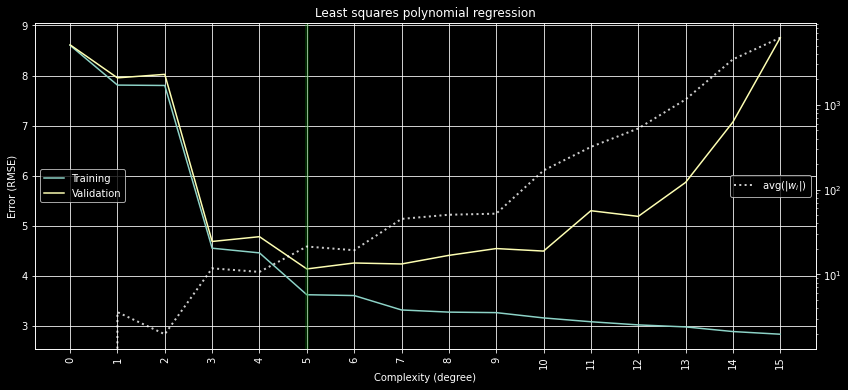

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

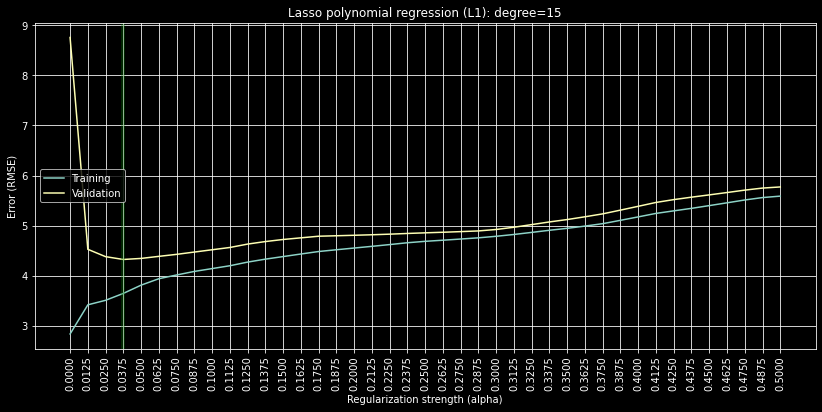

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

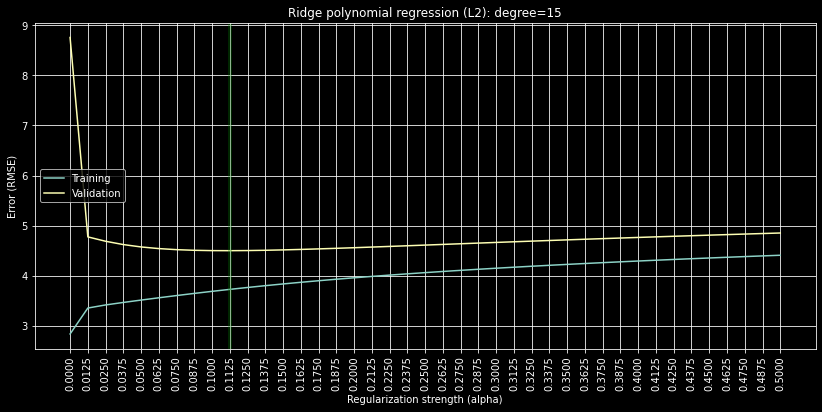

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
# print(data['DESCR'])
print('X_diabetes.shape, y_diabetes.shape', X_diabetes.shape, y_diabetes.shape)
print('feature_names', data['feature_names'], 'len:', len(data['feature_names']))

X_diabetes.shape, y_diabetes.shape (442, 10) (442, 1)
feature_names ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'] len: 10


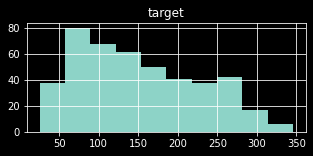

In [21]:
# гистограмма целевой переменной
_ = y_diabetes.hist(figsize=(5, 2))

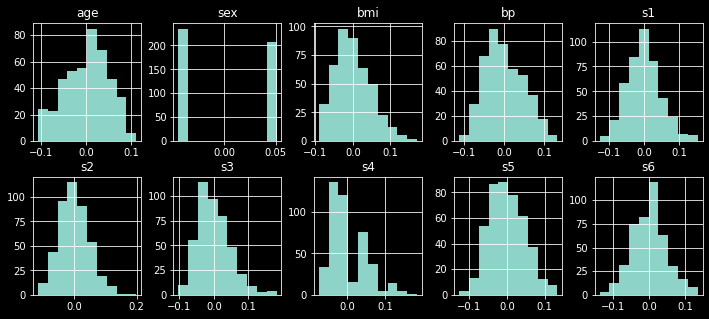

In [23]:
# гистограммы фич
fig, axs = plt.subplots(2, X_diabetes.shape[1] // 2, figsize=(12, 5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(X_diabetes.shape[1]):
    ax = axs[i]
    _ = ax.set_title(X_diabetes.columns[i])
    _ = X_diabetes.loc[:, X_diabetes.columns[i]].hist(ax=ax)

In [25]:
# довольно слабые корреляции с целевой переменной, всего лишь 0.6
df = pd.concat([X_diabetes, y_diabetes], axis=1)
round(df.corr()[np.abs(df.corr()) > 0.5], 2)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.59
bp,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s1,NaN,NaN,NaN,NaN,1.00,0.90,NaN,0.54,0.52,NaN,NaN
s2,NaN,NaN,NaN,NaN,0.90,1.00,NaN,0.66,NaN,NaN,NaN
s3,NaN,NaN,NaN,NaN,NaN,NaN,1.00,-0.74,NaN,NaN,NaN
s4,NaN,NaN,NaN,NaN,0.54,0.66,-0.74,1.00,0.62,NaN,NaN
s5,NaN,NaN,NaN,NaN,0.52,NaN,NaN,0.62,1.00,NaN,0.57
s6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


y_train + y_test


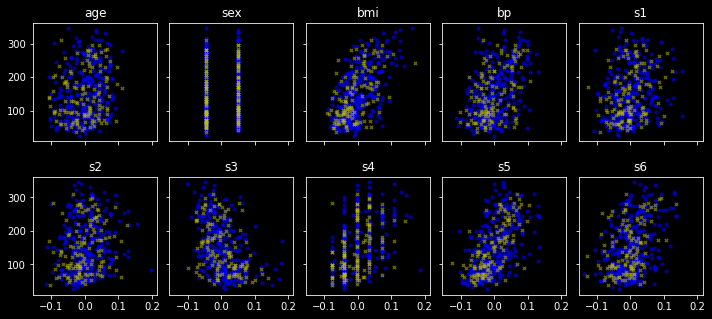

In [26]:
# равномерность распределение трейна и теста
X_train, X_test, y_train, y_test = train_test_split(
    X_diabetes, y_diabetes, test_size=0.3, random_state=SEED
)
fig, axs = plt.subplots(2, X_diabetes.shape[1] // 2, figsize=(12, 5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
axs = axs.ravel()
print('y_train + y_test')
for i in range(X_train.shape[1]):
    ax = axs[i]
    _ = ax.set_title(X_train.columns[i])
    _ = ax.scatter(X_train.loc[:, X_train.columns[i]], y_train, c="b", s=10, alpha=0.5)
    _ = ax.scatter(X_test.loc[:, X_test.columns[i]], y_test, marker='x', c="y", s=10, alpha=0.5)

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

linearregression coef_ (1, 11) var: 176405.0
rmse train: 54.1
rmse test: 53.1


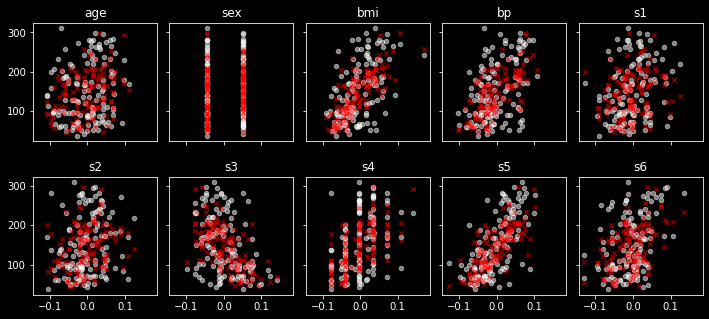

In [44]:
# вместо make_model тут make_pipeline(PolynomialFeatures(degree), LinearRegression())
def plot_y_pred(degree=2, X=X_test, y=y_test):
    fig, axs = plt.subplots(2, X_diabetes.shape[1] // 2, figsize=(12, 5), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.1)
    axs = axs.ravel()
    pipe = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    pipe.fit(X_train, y_train)
    print('linearregression coef_', pipe['linearregression'].coef_.shape, 
        'var:', pipe['linearregression'].coef_.var().round(2))
    y_pred = pipe.predict(X_train).reshape(-1)
    print(f"rmse train: {rmse(y_pred, y_train).round(1)}")
    y_pred = pipe.predict(X_test).reshape(-1)
    print(f"rmse test: {rmse(y_pred, y_test).round(1)}")
    y_pred = pipe.predict(X).reshape(-1)
    params = {"s": 20, "alpha": 0.5}
    for i in range(X_train.shape[1]):
        ax = axs[i]
        ax.set_title(X.columns[i])
        ax.scatter(X.loc[:, X.columns[i]], y, marker="o", c="w", **params)
        ax.scatter(X.loc[:, X.columns[i]], y_pred, marker="x", c="r", **params)
# Ручной режим. Меняем degree, сравнивем настоящие и предсказанные значения
# для трейн (белый) или тест (красный).
# Смотрим rmse и коэффициенты. Разница в rmse увеличивается при росте degree.
degree = 1
# plot_y_pred(degree=degree, X=X_train, y=y_train) # точное попадание начиная с degree = 4
plot_y_pred(degree=degree, X=X_test, y=y_test) # с degree = 3 всё очень плохо

In [45]:
# Мало приятного ждать несколько часов пока ноутбук выполнится, поэтому
# берем только парочку фич. Думаю достаточно, чтобы исполнить то, что подразумевалось автором задания
X_train, X_test, y_train, y_test = train_test_split(
    X_diabetes[['s1','s2']], y_diabetes, test_size=0.3, random_state=SEED
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((309, 2), (133, 2), (309, 1), (133, 1))

linearregression coef_ (1, 136) var: 5.1912532071942955e+32
rmse train: 69.1
rmse test: 5614.0
linearregression coef_ (1, 136) var: 5.1912532071942955e+32
rmse train: 69.1
rmse test: 5614.0


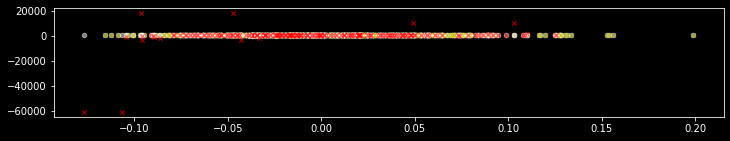

In [52]:
def plot_y_pred(degree=2, X=X_test, y=y_test, ax=None, c='g'):
    pipe = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    pipe.fit(X_train, y_train)
    print('linearregression coef_', pipe['linearregression'].coef_.shape, 
        'var:', pipe['linearregression'].coef_.var().round(2))
    y_pred = pipe.predict(X_train).reshape(-1)
    print(f"rmse train: {rmse(y_pred, y_train).round(1)}")
    y_pred = pipe.predict(X_test).reshape(-1)
    print(f"rmse test: {rmse(y_pred, y_test).round(1)}")
    y_pred = pipe.predict(X).reshape(-1)
    params = {"s": 20, "alpha": 0.5}
    for n in range(X.shape[1]):
        ax.scatter(X.values[:, n], y, marker="o", c="w", **params)
        ax.scatter(X.values[:, n], y_pred, marker="x", c=c, **params)

# Ручной режим.
degree = 15
fig, ax = plt.subplots(figsize=(12, 2))
# белый - целевая переменная, желтый - предсказание на трейне, красный - на тесте
plot_y_pred(degree=degree, X=X_train, y=y_train, ax=ax, c="y")
plot_y_pred(degree=degree, X=X_test, y=y_test, ax=ax, c="r")

X, y shapes: (442, 10) (442, 1)


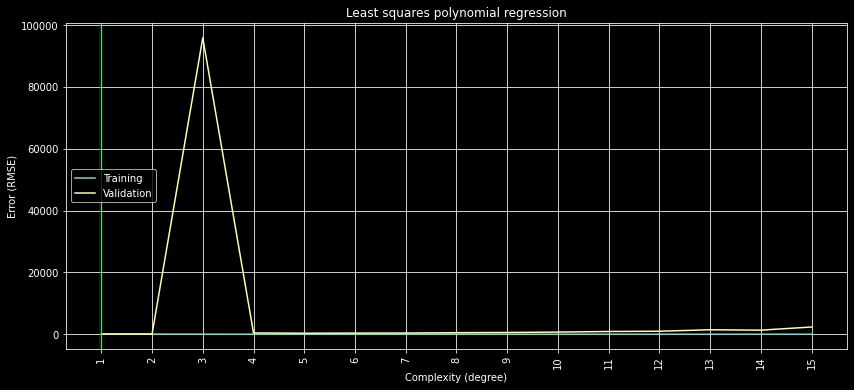

In [53]:
# Берем все фичи.
print('X, y shapes:', X_diabetes.shape, y_diabetes.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X_diabetes, y_diabetes, test_size=0.3, random_state=SEED
)
# когда degree == 0 то ошибка:
# "could not broadcast input array from shape (309,10) into shape (309,0)"
# поэтому поменял DEGREES чтобы начиналось с 1, а не с 0.
DEGREES = np.linspace(1, 15, 15, dtype=int)
# Выполняется где-то 15 минут, поэтому код дающий эти значения закоменчен, 
# просто выводятся скопированные константы в виде графика.
rmse_train = [
    54.074408724527814,
    49.08764167521052,
    20.54773581801581,
    1.310215724586141e-12,
    6.213593314900179e-13,
    6.542724387564327e-13,
    1.0026975394912909e-12,
    1.4716305628951415e-12,
    2.0103032916500882e-12,
    4.330487851289714e-12,
    5.94182369174952e-12,
    9.419012944323026e-12,
    1.733069160303394e-11,
    2.8684266014676474e-11,
    4.5717816743809903e-11,
]
rmse_test = [
    53.12003915269996,
    56.31949331234652,
    95954.19846889407,
    415.44900789783736,
    322.1132895929528,
    365.61960834633294,
    384.54966890569466,
    494.0351606834293,
    555.1316416577565,
    694.1432992877725,
    883.3352847086551,
    967.2374018044574,
    1443.9993758875978,
    1313.868690534551,
    2335.9045166024607,
]
# Если надо воспроизвести, то можно раскоментить этот код.
# rmse_train, rmse_test = [], []
# for degree in DEGREES:
#     reg = make_model(degree).fit(X_train, y_train)
#     rmse_train.append(rmse(reg.predict(X_train), y_train))
#     rmse_test.append(rmse(reg.predict(X_test), y_test))
plot_fitting_graph(
    DEGREES,
    rmse_train,
    rmse_test,
    xlabel="Complexity (degree)",
    ylabel="Error (RMSE)",
    title="Least squares polynomial regression",
)

In [54]:
# your findings/conclusions
# Это выводы для случая использования всех фич, но в чпстью фич всё очень похоже.
# degree=1 rmse train: 54.1 test: 53.1 (лучшее значение ошибки на тесте)
# degree=2 rmse train: 49.1 test: 56.3 (близко к degree=1), 
# degree=3 оверфит. Резкий (в небеса) взлёт ошибки на тесте, не знаю почему.
# degree=4 ошибка на трейне 0, а на тесте 400..500, что гораздо ниже, чем при degree=3.
# дальше примерно однаково, на тесте ошибка немного растет.
#
# Ошибка на трейне быстро сходится к 0, но на тесте расходится. Оверфит.

In [55]:
# берем только пару фич
X_diabetes.shape, y_diabetes.shape
if X_diabetes.shape[1] == 10:
    X_diabetes = X_diabetes[['s1','s2']].values
    y_diabetes = y_diabetes.values
    X_diabetes.shape, y_diabetes.shape

((442, 10), (442, 1))

((442, 2), (442, 1))

In [57]:
# теперь с cross_validate и make_model
for degree in [5, 10, 15, 20, 25]:
    results = cross_validate(
        make_model(degree=degree),
        X_diabetes,
        y_diabetes,
        cv=5,
        return_estimator=True,
        return_train_score=True,
        scoring="neg_root_mean_squared_error",
    )
    mv = np.mean([model['reg'].coef_.var() for model in results['estimator']]).round(2)
    # резкий рост ошибки на тесте
    print("degree:", degree,
          "train err:", -np.mean(results["train_score"]).round(2),
          "test  err:", -np.mean(results["test_score"]).round(2))
    print('coef_ mean variance:', mv)
    # print('coef_:', [model['reg'].coef_.round(1) for model in results['estimator']])

degree: 5 train err: 73.72 test  err: 95.3
coef_ mean variance: 30648859.16
degree: 10 train err: 68.64 test  err: 19360.67
coef_ mean variance: 1.064884936513621e+18
degree: 15 train err: 64.63 test  err: 59678119.24
coef_ mean variance: 1.1141996754400002e+28
degree: 20 train err: 58.91 test  err: 429995288979.89
coef_ mean variance: 1.2465991728697578e+28
degree: 25 train err: 62.58 test  err: 624605076480356.1
coef_ mean variance: 8.568254930076139e+27


In [65]:
# функция для сохранения результатов в одну переменную save_stats
def save_stats(results, save_stats, prefix):
    fmg = str(fixed_main_degree)
    mm = np.mean([model["reg"].coef_.mean() for model in results["estimator"]])
    mv = np.mean([model["reg"].coef_.var() for model in results["estimator"]])
    # nz - 'n'umber of 'z'eros
    nz = np.sum(results["estimator"][0]['reg'].coef_ == 0.0)
    # процент нулевых коэффициентов = сколько нулей / сколько всего коэфф-ов
    nz = nz / results["estimator"][0]['reg'].coef_.reshape(-1).shape[0]

    if save_stats.get(fmg, -1) != -1:
        old_mv = save_stats[fmg].get(prefix + "mv", [])
        old_mm = save_stats[fmg].get(prefix + "mm", [])
        old_nz = save_stats[fmg].get(prefix + "nz", [])
    else:
        old_mv = []
        old_mm = []
        old_nz = []
    save_stats[fmg].update(
        {prefix + "mv": old_mv + [mv], 
         prefix + "mm": old_mm + [mm], 
         prefix + "nz": old_nz + [nz]}, **save_stats[fmg]
    )
    print(
        "fixed_main_degree:", fmg,
        "train:", -np.mean(results["train_score"]),
        "test:", -np.mean(results["test_score"]),
        "coef_ (mean mean):", mm,
        "(mean variance):", mv,
        "(zeros):", nz
    )
fixed_main_degree = 15
results = cross_validate(
    make_model(degree=fixed_main_degree),
    X_diabetes,
    y_diabetes,
    cv=5,
    return_estimator=True,
    return_train_score=True,
    scoring="neg_root_mean_squared_error",
)
compare_var = {str(fixed_main_degree):{}}
# lr - linear regression
save_stats(results, compare_var, "lr_")

fixed_main_degree: 15 train: 64.62674973111424 test: 59678119.241142474 coef_ (mean mean): 38827.70128535518 (mean variance): 1.1141996754400002e+28 (zeros): 0.0


In [66]:
# это для последующего сравнения
compare_var

{'15': {'lr_mv': [1.1141996754400002e+28],
  'lr_mm': [38827.70128535518],
  'lr_nz': [0.0]}}

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [ ]:
# Сколько коэффициентов на двух poly переменных для разных степеней degree? (просто на память)
# (3 + 1) * (3 + 2) / 2 - 1 = 9, (4 + 1) * (4 + 2) / 2 - 1 = 14, (5 + 1) * (5 + 2) / 2 - 1 = 20
# (15 + 1) * (15 + 2) / 2 - 1 = 135

In [67]:
## your code
# на низких значениях регуляризации модель предупреждает что не сходится, поэтому пропускаю их
for alpha in ALPHAS[ALPHAS > 0.0625]:
    print('alpha:', alpha)
    results = cross_validate(
        make_model(degree=fixed_main_degree, penalty='L1', alpha=alpha),
        X_diabetes,
        y_diabetes,
        cv=5,
        return_estimator=True,
        return_train_score=True,
        scoring="neg_root_mean_squared_error",
    )
    save_stats(results, compare_var, 'L1_')

alpha: 0.07500000000000001
fixed_main_degree: 15 train: 74.17586426620753 test: 91.55570836330756 coef_ (mean mean): 0.09544414034871253 (mean variance): 92.39045304273573 (zeros): 0.8740740740740741
alpha: 0.08750000000000001
fixed_main_degree: 15 train: 74.2474313164284 test: 85.72595477318471 coef_ (mean mean): 0.09472361623069576 (mean variance): 61.80584452964151 (zeros): 0.9037037037037037
alpha: 0.1
fixed_main_degree: 15 train: 74.30848026870369 test: 84.83167783898331 coef_ (mean mean): 0.09385280753186441 (mean variance): 42.67801362301334 (zeros): 0.9185185185185185
alpha: 0.1125
fixed_main_degree: 15 train: 74.3585062559519 test: 89.41760847552165 coef_ (mean mean): 0.09311806231086686 (mean variance): 32.63162391314237 (zeros): 0.9185185185185185
alpha: 0.125
fixed_main_degree: 15 train: 74.3889336294562 test: 88.5241749425334 coef_ (mean mean): 0.09289110081715386 (mean variance): 26.09936587364619 (zeros): 0.9333333333333333
alpha: 0.1375
fixed_main_degree: 15 train: 74.4

In [69]:
# L1
# среднее примерно на месте
' '.join([f'{x:.3f}' for x in compare_var[str(fixed_main_degree)]['L1_mm']])
# дисперсия уменьшается
' '.join([f'{x:.3f}' for x in compare_var[str(fixed_main_degree)]['L1_mv']])

'0.095 0.095 0.094 0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.094 0.094 0.094 0.094 0.094 0.094 0.094 0.094 0.094 0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.092 0.092 0.092 0.092 0.092 0.092'

'92.390 61.806 42.678 32.632 26.099 20.956 16.987 13.915 11.993 10.453 9.474 8.918 8.721 8.271 7.818 7.476 7.131 6.814 6.548 6.259 5.996 5.799 5.646 5.492 5.358 5.228 5.121 5.039 4.902 4.751 4.586 4.446 4.320 4.190 4.079'

#### L2

In [70]:
## your code
for alpha in ALPHAS:
    print('alpha:', alpha)
    results = cross_validate(
        make_model(degree=fixed_main_degree, penalty='L2', alpha=alpha),
        X_diabetes,
        y_diabetes,
        cv=2,
        return_estimator=True,
        return_train_score=True,
        scoring="neg_root_mean_squared_error",
    )
    save_stats(results, compare_var, 'L2_')

alpha: 0.0
fixed_main_degree: 15 train: 59.986966396930754 test: 1298448774.952131 coef_ (mean mean): 119307.48621102792 (mean variance): 1.4800053706388124e+28 (zeros): 0.0
alpha: 0.0125
fixed_main_degree: 15 train: 71.9404223292098 test: 2139.0956106926205 coef_ (mean mean): 0.14351987515762243 (mean variance): 5671.518522658716 (zeros): 0.0
alpha: 0.025
fixed_main_degree: 15 train: 72.14582668529799 test: 865.2870283749472 coef_ (mean mean): 0.13390185869043464 (mean variance): 2869.2765026092384 (zeros): 0.0
alpha: 0.037500000000000006
fixed_main_degree: 15 train: 72.26441009501461 test: 386.70919979540486 coef_ (mean mean): 0.1283151309447555 (mean variance): 1946.757080025508 (zeros): 0.0
alpha: 0.05
fixed_main_degree: 15 train: 72.34937472364467 test: 150.1649555928906 coef_ (mean mean): 0.12439341772957846 (mean variance): 1480.1952002733854 (zeros): 0.0
alpha: 0.0625
fixed_main_degree: 15 train: 72.41612071980968 test: 95.47617663047005 coef_ (mean mean): 0.12140838359134905 (

In [71]:
# L2
# среднее чуть уменьшается, первое значение - при нулевой регуляризации
' '.join([f'{x:.3f}' for x in compare_var[str(fixed_main_degree)]['L2_mm']])
# дисперсия снижается
' '.join([f'{x:.3f}' for x in compare_var[str(fixed_main_degree)]['L2_mv']])

'119307.486 0.144 0.134 0.128 0.124 0.121 0.119 0.117 0.115 0.114 0.113 0.112 0.111 0.110 0.109 0.109 0.108 0.107 0.107 0.106 0.106 0.105 0.105 0.105 0.104 0.104 0.104 0.103 0.103 0.103 0.103 0.102 0.102 0.102 0.102 0.102 0.101 0.101 0.101 0.101 0.101'

'14800053706388123934405951488.000 5671.519 2869.277 1946.757 1480.195 1196.293 1004.728 866.576 762.173 680.476 614.791 560.823 515.685 477.368 444.430 415.807 390.702 368.500 348.723 330.993 315.007 300.518 287.325 275.261 264.186 253.983 244.554 235.812 227.686 220.113 213.038 206.413 200.196 194.352 188.848 183.654 178.745 174.099 169.695 165.514 161.540'

In [73]:
# средняя дисперсия коэффициентов для трех методов, увеличение регуляризации ведет
# к уменьшению значений коэффициентов и соответственно величины дисперсии.
'lr_mv', compare_var['15']['lr_mv']
'L1_mv', ' '.join([f'{x:.1f}' for x in compare_var['15']['L1_mv']])
'L2_mv', ' '.join([f'{x:.1f}' for x in compare_var['15']['L2_mv']])

('lr_mv', [1.1141996754400002e+28])

('L1_mv',
 '92.4 61.8 42.7 32.6 26.1 21.0 17.0 13.9 12.0 10.5 9.5 8.9 8.7 8.3 7.8 7.5 7.1 6.8 6.5 6.3 6.0 5.8 5.6 5.5 5.4 5.2 5.1 5.0 4.9 4.8 4.6 4.4 4.3 4.2 4.1')

('L2_mv',
 '14800053706388123934405951488.0 5671.5 2869.3 1946.8 1480.2 1196.3 1004.7 866.6 762.2 680.5 614.8 560.8 515.7 477.4 444.4 415.8 390.7 368.5 348.7 331.0 315.0 300.5 287.3 275.3 264.2 254.0 244.6 235.8 227.7 220.1 213.0 206.4 200.2 194.4 188.8 183.7 178.7 174.1 169.7 165.5 161.5')

In [75]:
# Среднее значение коэффициентов ближе к нулю там, где есть регуляризация (L1 и L2). 
# Первое значение в L2_mm - при нулевой регуляризации.
'lr_mm', compare_var['15']['lr_mm']
'L1_mm', ' '.join([f'{x:.1f}' for x in compare_var['15']['L1_mm']])
'L2_mm', ' '.join([f'{x:.1f}' for x in compare_var['15']['L2_mm']])

('lr_mm', [38827.70128535518])

('L1_mm',
 '0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1')

('L2_mm',
 '119307.5 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1')

In [76]:
# процент нулей в L1 очень большой и растет с регуляризацией, в L2 их нет.
' '.join([f'{x*100:.1f}%' for x in compare_var[str(fixed_main_degree)]['L1_nz']])
' '.join([f'{x*100:.1f}%' for x in compare_var[str(fixed_main_degree)]['L2_nz']])

'87.4% 90.4% 91.9% 91.9% 93.3% 94.1% 93.3% 94.1% 93.3% 93.3% 94.1% 94.1% 92.6% 92.6% 92.6% 93.3% 92.6% 91.9% 93.3% 92.6% 91.9% 90.4% 89.6% 91.9% 90.4% 92.6% 93.3% 93.3% 92.6% 93.3% 91.1% 91.1% 91.1% 91.9% 91.9%'

'0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.0%'

#### Summary

In [77]:
# regularization methods are expected to constraint the weights (model coefficients). 
# Is it indeed happening? 
# Смотрим выше комментарии. Вроде бы всё происходит как надо.
# Средняя дисперсия (mv) коэффициентов модели самая низкая у L1, потом идет L2, и потом LinReg.
# Среднее среднего (mm) коэффициентов модели примерно равны у L1 и L2, у LinReg намного больше.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [42]:
# Is it indeed happening? 
# Я показал на предыдущем этапе, что при использовании L1 получается много нулей.
# В условии зачем-то появилось что-то непонятное про "объединить полиномиальные фичи с 
# неполиномиальными", поэтому использую ColumnTransformer, который это и делает, 
# на часть фич он использыется, остальные проходят (passthrough) через него как есть.

In [78]:
from sklearn.compose import ColumnTransformer

X_diabetes = pd.DataFrame(data["data"], columns=data["feature_names"])
y_diabetes = pd.DataFrame(data["target"], columns=["target"])
X_train, X_test, y_train, y_test = train_test_split(
    X_diabetes, y_diabetes, test_size=0.3, random_state=SEED
)
degree = 15
percent_of_zeros = []
for alpha in ALPHAS[1:]:
    pipe = make_pipeline(
        ColumnTransformer(
            [("pf", PolynomialFeatures(degree), ["s1", "s2"])], remainder="passthrough"
        ),
        Lasso(alpha=alpha, random_state=SEED, max_iter=50000),
    )
    _ = pipe.fit(X_train, y_train)
    percent_of_zeros.append(
        np.sum(pipe["lasso"].coef_ == 0) / pipe["lasso"].coef_.reshape(-1).shape[0]
    )

print("coef_ shape", pipe["lasso"].coef_.shape)
print(" ".join([f"{x*100:.0f}%" for x in percent_of_zeros]))

coef_ shape (144,)
93% 94% 94% 94% 94% 94% 95% 95% 95% 95% 95% 95% 95% 96% 96% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97% 97%


#### L2

In [79]:
## your code
degree = 15
percent_of_zeros = []
for alpha in ALPHAS[1:]:
    pipe = make_pipeline(
        ColumnTransformer(
            [("pf", PolynomialFeatures(degree), ["s1", "s2"])], remainder="passthrough"
        ),
        Ridge(alpha=alpha, random_state=SEED, max_iter=50000),
    )
    _ = pipe.fit(X_train, y_train)
    percent_of_zeros.append(
        np.sum(pipe["ridge"].coef_ == 0) / pipe["ridge"].coef_.reshape(-1).shape[0]
    )

print("coef_ shape", pipe["ridge"].coef_.shape)
print(" ".join([f"{x*100:.1f}%" for x in percent_of_zeros]))

coef_ shape (1, 144)
0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7% 0.7%


#### Summary

In [119]:
# your findings/conclusions
# У L1 много нулей, которые означают, что есть много почти ничего не значащих коэффициентов 
# или других проблем - оверфита, отсутствия нормализации и неправильной регуляризации.
# Эксперементируя с разными degree, заметил такое, что при избыточном значении degree
# когда модель уже всё хорошо предсказывает, добавление степеней лишь добавляет нули или 
# очень маленькие значения (см. ниже).
# L2 не имеет такой особенности сводить коэффициенты к нулю.

[ True False False False False False False False False False False False
 False False False False]


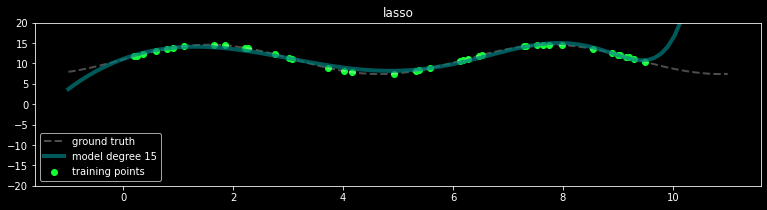

In [122]:
# Измененный пример из документации.
def f(x):
    """целевая переменная"""
    return 11 + 3.6 * np.sin(1.01 * x)
x_plot = np.linspace(-1, 11, 100)
x_train = np.linspace(0, 10, 200)
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=40, replace=False))
y_train = f(x_train)
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]
fig, ax = plt.subplots(figsize=(13, 3))
ax.set_prop_cycle(color=["w", "teal", "yellowgreen", "gold", "darkorange", "r", "g"])
ax.plot(x_plot, f(x_plot), "--", linewidth=2, label="ground truth", alpha=0.3)
ax.scatter(x_train, y_train, label="training points", c="#11ff33")
use_model = "lasso"
# use_model = "ridge"
# При degree 15 - очень маленьких значений (10^-14) коэффициентов нет
# но по мере увеличения degree они появляются в конце.
# Ручной режим, увеличиваем на 1 с 15 до 25, смотрим сколько True.
degree = 15
if use_model == "lasso":
    model = make_pipeline(
        PolynomialFeatures(degree), Lasso(alpha=0.0000000001, max_iter=10000, tol=0.02)
    )
else:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
model.fit(X_train, y_train)
print(f"{ np.abs(model[use_model].coef_) < 1.0e-14}")
y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, lw=4, alpha=0.7, label=f"model degree {degree}")
ax.legend(loc="lower left")
ax.set_ylim(-20, 20)
ax.set_title(use_model);

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [123]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [124]:
X_hw.shape, y_hw.shape

((50, 3), (50,))

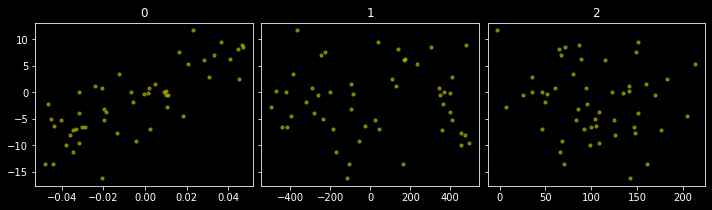

In [125]:
# видим 3 фичи с разными диапазонами и смещениями
fig, axs = plt.subplots(1, X_hw.shape[1], figsize=(12, 3), sharey=True)
fig.subplots_adjust(wspace=0.04)
axs = axs.ravel()
for i in range(X_hw.shape[1]):
    ax = axs[i]
    _ = ax.set_title(str(i))
    _ = ax.scatter(X_hw[:, i], y_hw, c="y", s=10, alpha=0.6)

In [126]:
# фича 0 имеет корреляцию, остальные - просто шум
ALPHAS = np.linspace(.1, 5.5, 100)

#### L1

(100, 3)

'многовато нулей в фиче 0, аж 99 из 100'

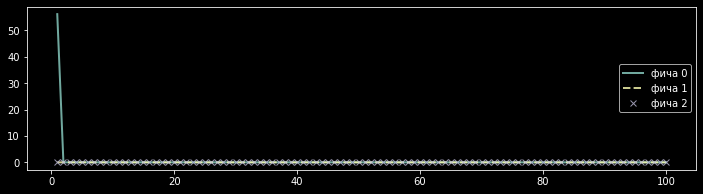

In [129]:
## your code
fig, ax = plt.subplots(figsize=(12, 3))
x_plot = np.linspace(1, len(ALPHAS), len(ALPHAS))
coefs = []
for alpha in ALPHAS:
    pipe = make_pipeline(Lasso(alpha=alpha, random_state=SEED))
    _ = pipe.fit(X_hw, y_hw)
    coefs.append(pipe["lasso"].coef_)
coefs = np.array(coefs)
coefs.shape
_ = ax.plot(x_plot, coefs[:, 0], "-", linewidth=2, label="фича 0", alpha=0.8)
_ = ax.plot(x_plot, coefs[:, 1], "--", linewidth=2, label="фича 1", alpha=0.8)
_ = ax.plot(x_plot, coefs[:, 2], "x", linewidth=2, label="фича 2", alpha=0.8)
_ = ax.legend(loc="right")
# _ = ax.set_ylim(ymin=0, ymax=0.1)
f"многовато нулей в фиче 0, аж {np.sum(coefs[:, 0] == 0.0)} из {coefs.shape[0]}" 

('С нормализацией получилось нулей:', 7)

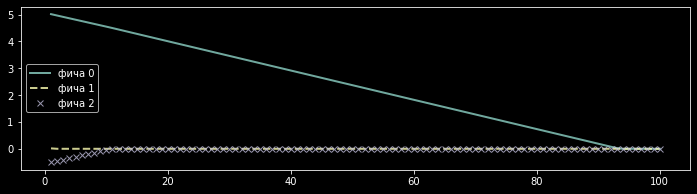

In [131]:
# то же самое но с StandardScaler
fig, ax = plt.subplots(figsize=(12, 3))
coefs = []
for alpha in ALPHAS:
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=alpha, random_state=SEED))
    _ = pipe.fit(X_hw, y_hw)
    coefs.append(pipe["lasso"].coef_)
coefs = np.array(coefs)
_ = ax.plot(x_plot, coefs[:, 0], "-", linewidth=2, label="фича 0", alpha=0.8)
_ = ax.plot(x_plot, coefs[:, 1], "--", linewidth=2, label="фича 1", alpha=0.8)
_ = ax.plot(x_plot, coefs[:, 2], "x", linewidth=2, label="фича 2", alpha=0.8)
_ = ax.legend(loc="center left")
# _ = ax.set_ylim(ymin=0, ymax=0.1)
"С нормализацией получилось нулей:", np.sum(coefs[:, 0] == 0.0)

#### L2

('нулей', 0)

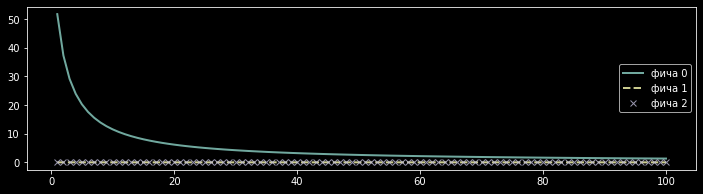

In [132]:
## your code
fig, ax = plt.subplots(figsize=(12, 3))
coefs = []
for alpha in ALPHAS:
    pipe = make_pipeline(Ridge(alpha=alpha, random_state=SEED))
    _ = pipe.fit(X_hw, y_hw)
    coefs.append(pipe["ridge"].coef_)
coefs = np.array(coefs)
_ = ax.plot(x_plot, coefs[:, 0], "-", linewidth=2, label="фича 0", alpha=0.8)
_ = ax.plot(x_plot, coefs[:, 1], "--", linewidth=2, label="фича 1", alpha=0.8)
_ = ax.plot(x_plot, coefs[:, 2], "x", linewidth=2, label="фича 2", alpha=0.8)
_ = ax.legend(loc="right")
"нулей", np.sum(coefs[:, 0] == 0.0)

('нулей', 0)

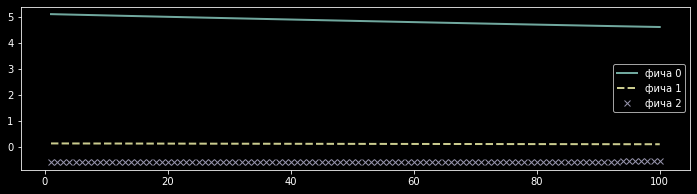

In [133]:
fig, ax = plt.subplots(figsize=(12, 3))
coefs = []
for alpha in ALPHAS:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha, random_state=SEED))
    _ = pipe.fit(X_hw, y_hw)
    coefs.append(pipe["ridge"].coef_)
coefs = np.array(coefs)
_ = ax.plot(x_plot, coefs[:, 0], "-", linewidth=2, label="фича 0", alpha=0.8)
_ = ax.plot(x_plot, coefs[:, 1], "--", linewidth=2, label="фича 1", alpha=0.8)
_ = ax.plot(x_plot, coefs[:, 2], "x", linewidth=2, label="фича 2", alpha=0.8)
_ = ax.legend(loc="right")
"нулей", np.sum(coefs[:, 0] == 0.0)

#### Summary



In [ ]:
## your observations/conclusions

# У L1 без нормализации коэффициенты как-то слишком быстро обнулились. Видимо потому, 
# что диапазон этой фичи очень маленький по сравнению с другими 2. Т.е. фича судя по 
# графику была полезная, имела заметную корреляцию, но обнулилась из-за бесполезных фич,
# у которых корреляции нет, но есть большие значения.

# Думаю у L2 это не так важно, т.к. нет особенности обнуления. Т.е. L2 более устойчива.

# Тут видимо должна быть мысль, что регуляризация сконцентрирована на разнице значений между фичами.
# Лучше привести фичи к одному диапазону и смещению, чтобы дать регуляризации действовать
# как задумано.

# Судя по графику для L2 нормализация сильно ускорила поиск оптимального значения alpha.